In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [21]:
words = open('../names.txt','r').read().splitlines()
print(words[:8])
print(len(words))


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [22]:
chars = sorted(list(set(''.join(words)))) # created a sorted list of all the possible characters
stoi = {s:i+1 for i,s in enumerate(chars)} # create a mapping of characters to integers
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [30]:
block_size = 3 # number of characters to use to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size # creates a list of 0's matching block size when starting a word
        for ch in w + '.':
            # each character of the word has the context appended to X, and the integer value in Y, then slide the context appending the integer value
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [21]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        #p = N[ix].float()
        #p = p / p.sum()
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [22]:
# how do we calcualate the loss of the model for evaluation
# lets get the log likelihood which is the product of the probabilities
# likelihood is a*b*c
# log likelihood = log(abc) = log(a) + log(b)+ log(c) for easier calculation
log_likelihood = 0.0
n = 0
for w in words:
#for w in ['sidh']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2] # getting the probability that the model predicted bigrams from the training set. Want > 4%
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood # use negative ll so that lower loss is better, lowest is zero
print(f'{nll=}')
print(f'{nll/n=}') # normalizing with average

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
nll/n=tensor(2.4544)


The above builds a name generator using bigrams, and statistical analysis of the bigrams to train the model with counts/probability distributions. Then sampling new names from these distributions.
Evaluating the performance of the model with negative log likelihood

Now take an approach using a NN based on bigrams
input - character
output - probability distribution of what should be the next character
loss - output vs. what the next character of the bigram should be
optimize through tuning with gradient descent

In [23]:
# Create training set of bigrams
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
        


. e
e m
m m
m a
a .


In [24]:
xs

tensor([ 0,  5, 13, 13,  1])

In [25]:
ys

tensor([ 5, 13, 13,  1,  0])

In [26]:
# we want to one hot encode these integers
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [27]:
xenc.shape

torch.Size([5, 27])

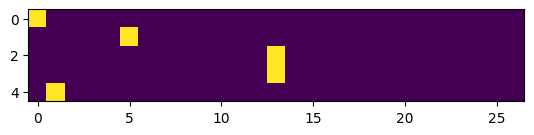

In [28]:
plt.imshow(xenc)

In [29]:
xenc.dtype

torch.float32

In [55]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27, generator=g, requires_grad=True) # create weights, one for each input from one hot by 27 neurons

## Begin forward pass

In [56]:
xenc @ W #(5, 27) @ (27,27) -> (5,27) taking dot product of each row of input with every column of weights

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00],
        [ 4.7236e-01,  1.4830e+00,  3.1748e-01,  1.0588e+00,  2.3982e+00,
          4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01,
          5.5570e-01,  4.7458e-01, -1.3867e+00,  1.6229e+00,  1.7197e-01,
          9.8846e-01,  5.0657e-01,  1.0198e+00, -1.9062e+00, -4.2753e-01,
         -2.1259e+00,  9.6041e-01],
        [ 1.9359e-01,  1.0532e+00,  6.3393e-01,  2.5786e-01,  9.6408e-01,
         -2.4855e-01,  2.4756e-02, -3.0404e-02,  1.5622e+00, -4.4852e-01,
         -1.2345e+00,  1.1220e+00, -6.73

In [32]:
(xenc @ W)[3,13]

tensor(0.0379)

In [33]:
xenc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [34]:
W[:,13]

tensor([-4.3297e-01, -9.6478e-01,  2.1346e+00, -7.2759e-01, -1.3753e-01,
        -1.3132e-03, -3.1566e-01,  1.1199e+00, -4.7701e-01, -1.5065e+00,
         1.2108e+00, -4.0636e-01,  1.9110e-01,  3.7882e-02,  1.3431e+00,
         2.4311e-01, -1.5364e-01, -1.1583e+00,  1.1614e+00,  4.2016e-01,
         2.7359e-01,  3.6583e-01,  1.7128e+00,  1.3769e+00, -8.9778e-01,
        -9.5177e-01,  1.4723e-01])

In [35]:
(xenc[3] * W[:,13]).sum()

tensor(0.0379)

In [52]:
logits = (xenc @ W) # Think of output of the layer as log outputs, and we want to exp to get to the real value and make things all positivek
# These are like counts being made by the NN, i.e. log counts are logits
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True) # this and the line above is softmax
probs

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

In [37]:
probs[0].sum()

tensor(1.0000)

In [38]:
probs.shape

torch.Size([5, 27])

In [39]:
probs[0] # represents the probabilities of the next letter being whatever corresponds to the index, this is what we will adjust by tuning the weights

tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])

In [53]:
nlls = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    print('------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x}, {y})')
    print('input to nn: ', x)
    print('output probs: ', probs[i])
    print('label: ', y)
    p = probs[i, y]
    print('prob predicted for the next char:', p.item())
    logp = torch.log(p)
    print('log likelihood: ', logp.item())
    nll = -logp
    print('neg log likelihood:', nll.item())
    nlls[i] = nll
    
print('=======')
print('avg neg log likelihood, i.e. loss = ', nlls.mean().item())


------
bigram example 1: .e (indexes 0, 5)
input to nn:  0
output probs:  tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
       grad_fn=<SelectBackward0>)
label:  5
prob predicted for the next char: 0.01228625513613224
log likelihood:  -4.399273872375488
neg log likelihood: 4.399273872375488
------
bigram example 2: em (indexes 5, 13)
input to nn:  5
output probs:  tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
       grad_fn=<SelectBackward0>)
label:  13
prob predicted for the next char: 0.018050700426101685
log likelihood:  -4.014570713043213
neg log likelihood: 4.014570713043213
------
bigram example 3

Pausing at https://www.youtube.com/watch?v=PaCmpygFfXo&t=5749s


In [57]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27, generator=g, requires_grad=True) # create weights, one for each input from one hot by 27 neurons

In [69]:
# Forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = (xenc @ W) # Think of output of the layer as log outputs, and we want to exp to get to the real value and make things all positivek
# These are like counts being made by the NN, i.e. log counts are logits
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True) # this and the line above is softmax
loss = -probs[torch.arange(5), ys].log().mean()

# Optimization


In [41]:
xs

tensor([ 0,  5, 13, 13,  1])

In [43]:
ys

tensor([ 5, 13, 13,  1,  0])

In [70]:
print(loss.item())

3.7291626930236816


In [44]:
probs[0,5], probs[1,13], probs[2,13], probs[3,1], probs[4,0]

(tensor(0.0123),
 tensor(0.0181),
 tensor(0.0267),
 tensor(0.0737),
 tensor(0.0150))

In [46]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [49]:
loss = -probs[torch.arange(5), ys].log().mean()

## Backward pass

In [71]:
W.grad = None # zero out gradient
loss.backward()


In [60]:
W.grad

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [61]:
W.shape

torch.Size([27, 27])

In [62]:
W.grad.shape

torch.Size([27, 27])

In [72]:
# Update
W.data += -0.1 * W.grad

In [ ]:
# Combining it all

In [92]:
# Create training set of bigrams
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples', num)
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27, 27, generator=g, requires_grad=True) # create weights, one for each input from one hot by 27 neurons

number of examples 228146


In [86]:
(W**2).sum()

tensor(1536.7556, grad_fn=<SumBackward0>)

In [90]:
# Gradient Descent
for k in range(100):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = (xenc @ W) # Think of output of the layer as log outputs, and we want to exp to get to the real value and make things all positivek
    # These are like counts being made by the NN, i.e. log counts are logits
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True) # this and the line above is softmax
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad

2.4829697608947754
2.4829440116882324
2.4829187393188477
2.482893466949463
2.4828693866729736
2.4828450679779053
2.482820987701416
2.482797622680664
2.482774019241333
2.4827513694763184
2.4827284812927246
2.4827065467834473
2.482684373855591
2.4826626777648926
2.4826409816741943
2.4826200008392334
2.4825992584228516
2.4825785160064697
2.482558250427246
2.4825379848480225
2.482517957687378
2.4824984073638916
2.4824793338775635
2.4824604988098145
2.4824414253234863
2.4824228286743164
2.4824042320251465
2.4823861122131348
2.4823684692382812
2.4823508262634277
2.482333183288574
2.482316255569458
2.4822990894317627
2.4822819232940674
2.4822654724121094
2.4822492599487305
2.4822330474853516
2.4822168350219727
2.482201337814331
2.4821853637695312
2.4821698665618896
2.482154607772827
2.4821391105651855
2.4821245670318604
2.482109785079956
2.4820950031280518
2.482081174850464
2.4820668697357178
2.4820523262023926
2.482038736343384
2.482024908065796
2.482011556625366
2.4819979667663574
2.4819846

Exercises:
E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

E06: meta-exercise! Think of a fun/interesting exercise and complete it.

In [132]:
# Create training set of tri
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append((ix1,ix2))
        ys.append(ix3)
        print(f'{(ch1,ch2)} {ch3}')
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = ys.nelement()
print(xs)
print('number of examples', num)
print('number of ys', ys.nelement())
g = torch.Generator().manual_seed(2147483647)
W = torch.randn(27*2, 27, generator=g, requires_grad=True) # create weights, one for each input from one hot by 27 neurons

('.', 'e') m
('e', 'm') m
('m', 'm') a
('m', 'a') .
('.', 'o') l
('o', 'l') i
('l', 'i') v
('i', 'v') i
('v', 'i') a
('i', 'a') .
('.', 'a') v
('a', 'v') a
('v', 'a') .
('.', 'i') s
('i', 's') a
('s', 'a') b
('a', 'b') e
('b', 'e') l
('e', 'l') l
('l', 'l') a
('l', 'a') .
('.', 's') o
('s', 'o') p
('o', 'p') h
('p', 'h') i
('h', 'i') a
('i', 'a') .
('.', 'c') h
('c', 'h') a
('h', 'a') r
('a', 'r') l
('r', 'l') o
('l', 'o') t
('o', 't') t
('t', 't') e
('t', 'e') .
('.', 'm') i
('m', 'i') a
('i', 'a') .
('.', 'a') m
('a', 'm') e
('m', 'e') l
('e', 'l') i
('l', 'i') a
('i', 'a') .
('.', 'h') a
('h', 'a') r
('a', 'r') p
('r', 'p') e
('p', 'e') r
('e', 'r') .
('.', 'e') v
('e', 'v') e
('v', 'e') l
('e', 'l') y
('l', 'y') n
('y', 'n') .
('.', 'a') b
('a', 'b') i
('b', 'i') g
('i', 'g') a
('g', 'a') i
('a', 'i') l
('i', 'l') .
('.', 'e') m
('e', 'm') i
('m', 'i') l
('i', 'l') y
('l', 'y') .
('.', 'e') l
('e', 'l') i
('l', 'i') z
('i', 'z') a
('z', 'a') b
('a', 'b') e
('b', 'e') t
('e', 't') h

('.', 'j') a
('j', 'a') d
('a', 'd') a
('d', 'a') n
('a', 'n') .
('.', 'j') a
('j', 'a') g
('a', 'g') .
('.', 'j') a
('j', 'a') h
('a', 'h') b
('h', 'b') a
('b', 'a') r
('a', 'r') i
('r', 'i') .
('.', 'j') a
('j', 'a') h
('a', 'h') l
('h', 'l') a
('l', 'a') n
('a', 'n') i
('n', 'i') .
('.', 'j') a
('j', 'a') h
('a', 'h') m
('h', 'm') i
('m', 'i') e
('i', 'e') r
('e', 'r') .
('.', 'j') a
('j', 'a') k
('a', 'k') a
('k', 'a') d
('a', 'd') e
('d', 'e') n
('e', 'n') .
('.', 'j') a
('j', 'a') k
('a', 'k') y
('k', 'y') e
('y', 'e') .
('.', 'j') a
('j', 'a') l
('a', 'l') o
('l', 'o') n
('o', 'n') i
('n', 'i') .
('.', 'j') a
('j', 'a') m
('a', 'm') o
('m', 'o') n
('o', 'n') t
('n', 't') e
('t', 'e') .
('.', 'j') a
('j', 'a') n
('a', 'n') d
('n', 'd') r
('d', 'r') i
('r', 'i') e
('i', 'e') l
('e', 'l') .
('.', 'j') a
('j', 'a') r
('a', 'r') r
('r', 'r') e
('r', 'e') t
('e', 't') .
('.', 'j') a
('j', 'a') s
('a', 's') h
('s', 'h') u
('h', 'u') a
('u', 'a') .
('.', 'j') a
('j', 'a') v
('a', 'v') a

In [136]:
# Gradient Descent
for k in range(100):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float().flatten(start_dim=1)
    #print(xenc)
    logits = (xenc @ W) # Think of output of the layer as log outputs, and we want to exp to get to the real value and make things all positivek
    # These are like counts being made by the NN, i.e. log counts are logits
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True) # this and the line above is softmax
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -50 * W.grad

2.2675418853759766
2.267361879348755
2.2671849727630615
2.2670109272003174
2.2668397426605225
2.266671895980835
2.2665066719055176
2.2663445472717285
2.2661843299865723
2.2660279273986816
2.2658731937408447
2.265721559524536
2.2655720710754395
2.265425205230713
2.2652804851531982
2.265138626098633
2.2649986743927
2.2648608684539795
2.2647249698638916
2.264591693878174
2.264460563659668
2.264331102371216
2.2642040252685547
2.264078378677368
2.2639548778533936
2.263833522796631
2.263713836669922
2.2635955810546875
2.263479709625244
2.2633652687072754
2.2632522583007812
2.263141393661499
2.2630319595336914
2.2629241943359375
2.262817859649658
2.2627129554748535
2.2626097202301025
2.262507915496826
2.2624077796936035
2.2623085975646973
2.2622110843658447
2.2621147632598877
2.2620203495025635
2.2619266510009766
2.2618343830108643
2.2617435455322266
2.2616536617279053
2.2615652084350586
2.2614777088165283
2.2613918781280518
2.2613065242767334
2.2612223625183105
2.2611398696899414
2.261058092